# Data Cleaning

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics

In [2]:
df = pd.read_csv('data-pozo/kc_house_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data-pozo/kc_house_data.csv'

In [23]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [24]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [25]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [26]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)
df["City"] = df["City"].apply(lambda x: x.strip())
df["ZIP"] = df["ZIP"].apply(lambda x: x.strip())
df["House_Num"] = df["House_Num"].apply(lambda x: x.strip())

In [27]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]

df.reset_index(drop = True, inplace = True)
df.drop(columns=['id', 'date', 'address', 'lat', 'long', 'House_Num', 'State_ZIP', 'Country', 'State'], inplace = True)

In [28]:
#initial clean dataset, dropping useless columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28971 entries, 0 to 28970
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          28971 non-null  float64
 1   bedrooms       28971 non-null  int64  
 2   bathrooms      28971 non-null  float64
 3   sqft_living    28971 non-null  int64  
 4   sqft_lot       28971 non-null  int64  
 5   floors         28971 non-null  float64
 6   waterfront     28971 non-null  object 
 7   greenbelt      28971 non-null  object 
 8   nuisance       28971 non-null  object 
 9   view           28971 non-null  object 
 10  condition      28971 non-null  object 
 11  grade          28971 non-null  object 
 12  heat_source    28971 non-null  object 
 13  sewer_system   28971 non-null  object 
 14  sqft_above     28971 non-null  int64  
 15  sqft_basement  28971 non-null  int64  
 16  sqft_garage    28971 non-null  int64  
 17  sqft_patio     28971 non-null  int64  
 18  yr_bui

# EDA

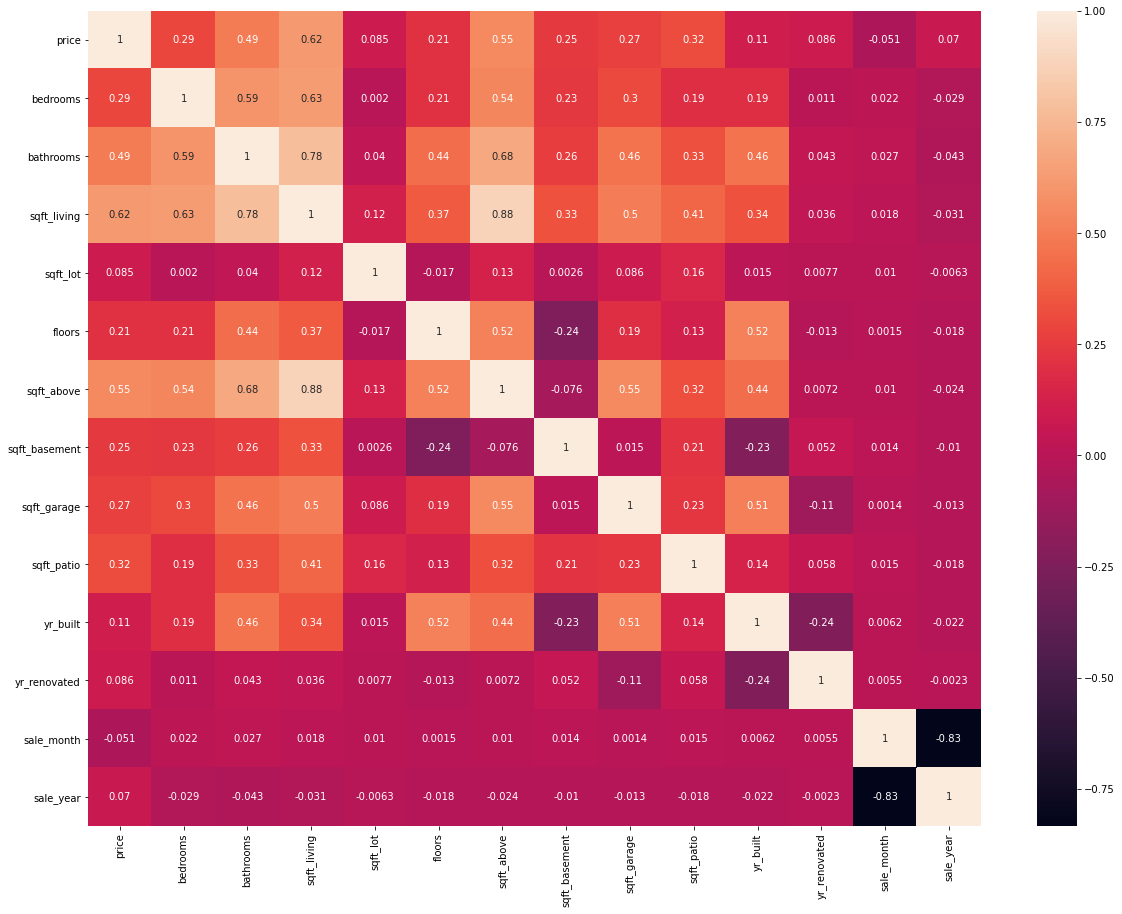

In [29]:
#Run heatmap to identify highly correlated variables to identify possible multi-colinearity 
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot = True)
plt.show();

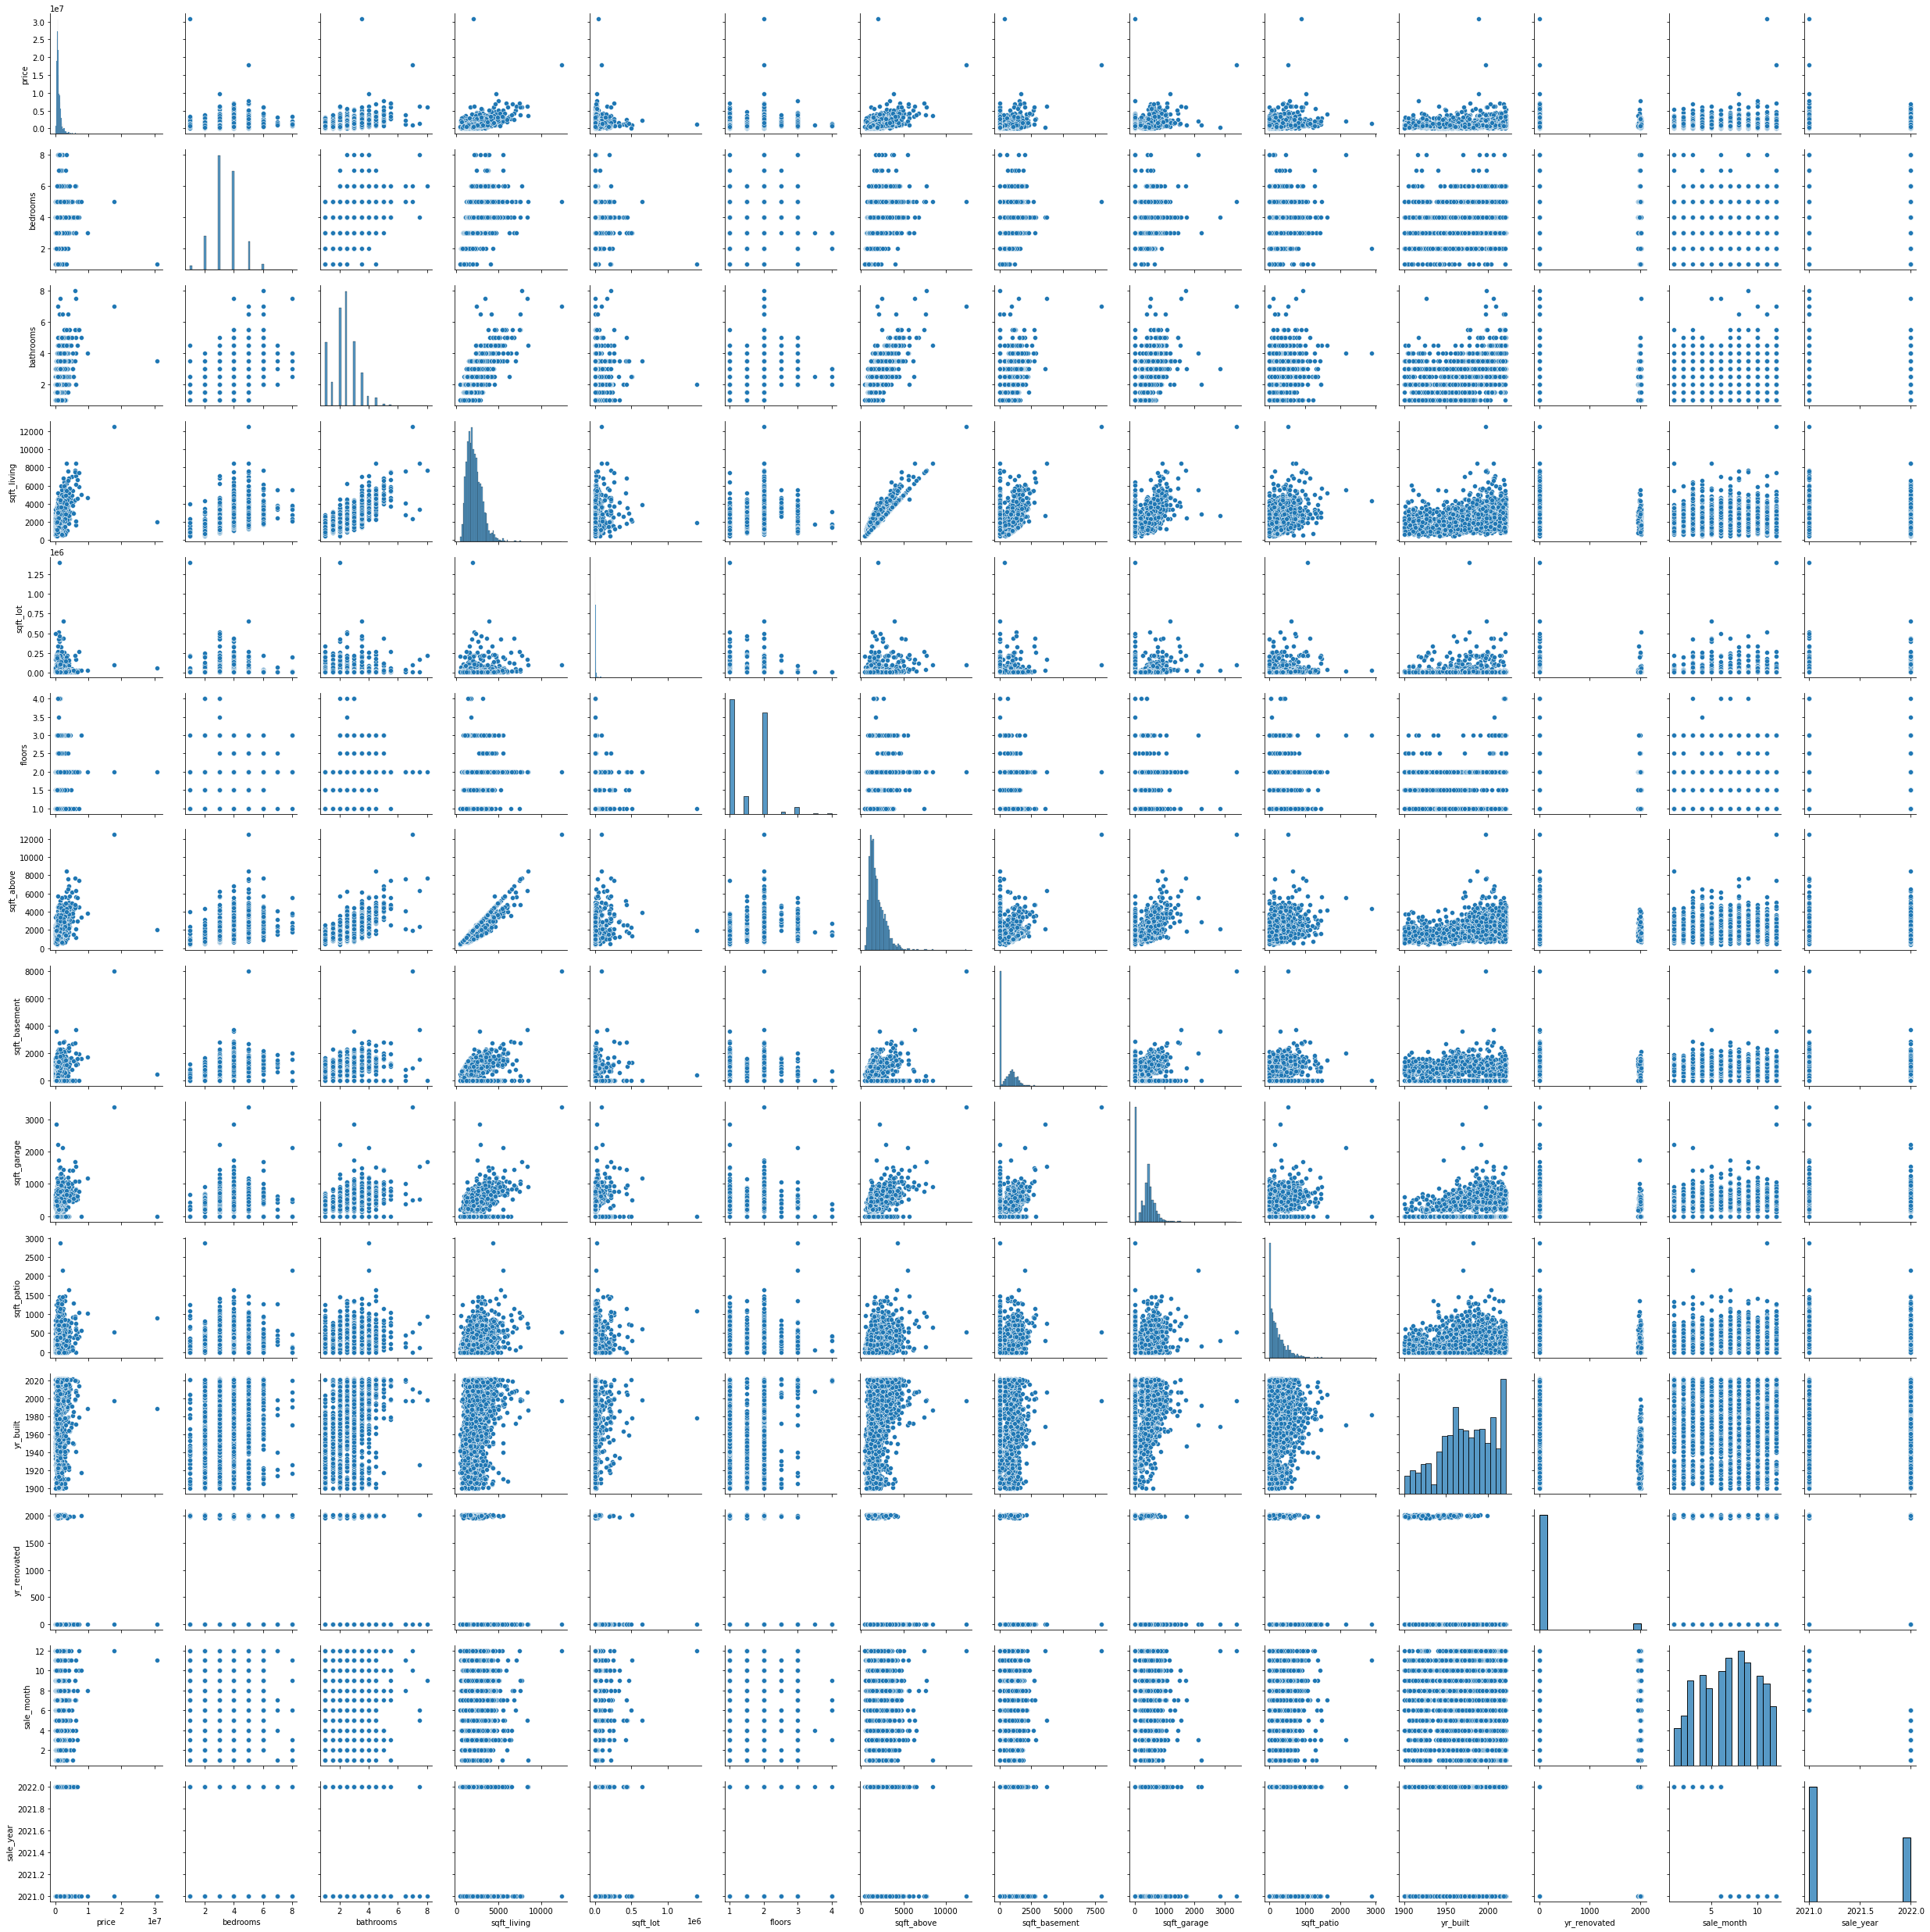

In [16]:
sns.pairplot(df.sample(3000));

1.) sqft_living is the most correlated feature with price 

2.) multi-colinearity between determinents of house size (sqft_living, bedrooms, bathrooms, basement, lot_size)

3.) target (price), sqft_living, sqft_above, sqft_patio not normally distributed. need to log

4.) potential interactions: sqft_lot-sqft-living, sqft_basement-sqft_garage

5.) sqft_living and sqft_above very colinear. probably need to drop one 


In [30]:
#Perform pre-processing transformations on non-normal columns 

df['log_price'] = np.log(df['price'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_above'] = np.log(df['sqft_above'])


# Baseline Model

In [33]:
# Baseline model will use the single most correlated feature from the original dataframe: sqft_living

model_cols = [ 
 'log_sqft_living']

X = df[model_cols]
y = df['log_price']

base_model = sm.OLS(y, sm.add_constant(X)).fit()
print(base_model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 1.588e+04
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        18:51:25   Log-Likelihood:                -19286.
No. Observations:               28971   AIC:                         3.858e+04
Df Residuals:                   28969   BIC:                         3.859e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.7561      0.048    1

# Model 1: Multi-Linear with Numerics Added

In [35]:
#removing year_renovated to become ordinal later on

model_cols = [ 
 'bedrooms',
 'bathrooms',
 'log_sqft_living',
 'sqft_lot',
 'floors',
 'log_sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'sale_month',
 'sale_year']

X = df[model_cols]
y = df['log_price']

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled,
                              columns=X.columns,
                              index=X.index)

model_1 = LinearRegression()
model_1.fit(X, y)
model_1.score(X, y)

model_1 = sm.OLS(y, sm.add_constant(X)).fit()
print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     1734.
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        19:00:19   Log-Likelihood:                -17775.
No. Observations:               28971   AIC:                         3.558e+04
Df Residuals:                   28958   BIC:                         3.568e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -339.6129     20.037    -